In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py

import numpy as np
import pandas as pd

import glob

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
def plot_wavefields(preds, trues, errors,timestep_to_plot,name_to_save=None):
    fig , axs = plt.subplots(3,len(timestep_to_plot),figsize=(len(timestep_to_plot)*2.7,7.5),squeeze=False)

    for row, ts in enumerate(timestep_to_plot):

        # True
        im_true = axs[1,row].imshow(trues[row,:,:],norm=MidpointNormalize(midpoint=0,vmin=trues.min(),vmax=trues.max()))
        clim = im_true.get_clim()

        # Predictions
        im_pred = axs[0,row].imshow(preds[row,:,:],norm=MidpointNormalize(midpoint=0),clim=clim)
        axs[0,row].set_title(f'Wavefield {ts}',fontsize=16)

        # Error
        im_error = axs[2,row].imshow(errors[row,:,:],norm=MidpointNormalize(midpoint=0,vmin=errors.min(),vmax=errors.max()))

        axs[0,row].tick_params(left=False,bottom=False)
        axs[0,row].set(yticklabels=[],xticklabels=[])
        axs[0,row].set_frame_on(False)
        axs[1,row].tick_params(left=False,bottom=False)
        axs[1,row].set(yticklabels=[],xticklabels=[])
        axs[1,row].set_frame_on(False)
        axs[2,row].tick_params(left=False,bottom=False)
        axs[2,row].set(yticklabels=[],xticklabels=[])
        axs[2,row].set_frame_on(False)

        axs[0,0].set_ylabel('Prediction',fontsize=16)
        axs[1,0].set_ylabel('True',fontsize=16)
        axs[2,0].set_ylabel('Error',fontsize=16)
    
    plt.tight_layout()
    
    # Colorbar
    divider = make_axes_locatable(axs[1,-1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im_true, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)

    divider = make_axes_locatable(axs[0,-1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im_pred, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)

    divider = make_axes_locatable(axs[2,-1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im_error, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)

    if name_to_save:
        plt.savefig(name_to_save,dpi=600,bbox_inches='tight')

In [4]:
# Train

error = np.load('models_output/Event0002/unet_errors_PINN_RES_E500.npy')
trues = np.load('models_output/Event0002/unet_trues_PINN_RES_E500.npy')
preds = np.load('models_output/Event0002/unet_preds_PINN_RES_E500.npy')

#plot_wavefields(preds, trues, error, [0,25,50,100,150],name_to_save='edges_crack_2_event2.pdf')

In [5]:
# Test

error = np.load('models_output/Event0005/unet_errors_PINN_RES_E500.npy')
trues = np.load('models_output/Event0005/unet_trues_PINN_RES_E500.npy')
preds = np.load('models_output/Event0005/unet_preds_PINN_RES_E500.npy')

#plot_wavefields(preds, trues, error, [0,25,50,100,150],name_to_save='edges_crack_2_event5.pdf')

In [6]:
events_train = ['Event0001','Event0002','Event0004','Event0006','Event0007','Event0008','Event0010','Event0011']
events_test = ['Event0000','Event0003','Event0005','Event0009']

In [7]:
df_train = pd.DataFrame()
for event in events_train:
    df_train.loc[:,event] = pd.read_csv(f'models_output/{event}/unet_PINN_RES_E500.csv',index_col=0)['rmse']

df_test = pd.DataFrame()
for event in events_test:
    df_test.loc[:,event] = pd.read_csv(f'models_output/{event}/unet_PINN_RES_E500.csv',index_col=0)['rmse']

In [8]:
df_train = pd.DataFrame()
for event in events_train:

    model_name = f'models_output/{event}/unet_PINN_RES_E500.csv'

    df_preds = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_pred'])['receivers_pred'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)
    df_trues = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_true'])['receivers_true'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)

    df_err = df_preds - df_trues
    df_err.columns = [ev +'_'+str(col) for ev, col in zip([event]*8,range(8))]

    df_train = pd.concat((df_train,df_err),axis=1)

df_test = pd.DataFrame()
for event in events_test:

    model_name = f'models_output/{event}/unet_PINN_RES_E500.csv'

    df_preds = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_pred'])['receivers_pred'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)
    df_trues = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_true'])['receivers_true'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)

    df_err = df_preds - df_trues
    df_err.columns = [ev +'_'+str(col) for ev, col in zip([event]*8,range(8))]

    df_test = pd.concat((df_test,df_err),axis=1)

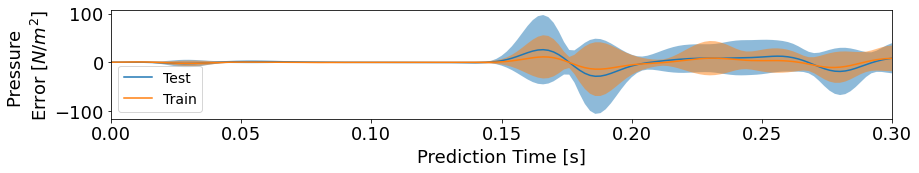

In [9]:
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(df_test.index,df_test.mean(axis=1),label='Test')
ax.fill_between(df_test.index,df_test.mean(axis=1) + df_test.std(axis=1),df_test.mean(axis=1) - df_test.std(axis=1),alpha=0.5)

ax.plot(df_train.index,df_train.mean(axis=1),label='Train')
ax.fill_between(df_train.index,df_train.mean(axis=1) + df_train.std(axis=1),df_train.mean(axis=1) - df_train.std(axis=1),alpha=0.5)

ax.set_ylabel('Pressure \nError $[N/m^2]$',fontsize = 18)
ax.set_xlabel('Prediction Time [s]',fontsize = 18)
ax.set_xlim(0,0.3)
ax.tick_params(axis='both', labelsize=18)

plt.legend(fontsize=14)
plt.savefig('edges_crack_2_errors_receivers.pdf',bbox_inches='tight')